In [1]:
import torch 
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose

class ImageDataset(Dataset):
    def __init__(self, image_dir, image_dir_2, transform=None):
        self.image_dir = image_dir
        self.image_dir_2 = image_dir_2
        self.image_files = [i for i in os.listdir(image_dir) if i.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        self.images_files_2 = [i for i in os.listdir(image_dir_2) if i.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        self.transform = transform
 
    def len(self):
        return len(self.image_files)

    def getItem(self, dirc, files, idx):
        img_path = os.path.join(dirc, files[idx])
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image  
    
    def getDataset(self, limit):
        total_dataset = []
        for i in range(1, limit):
            if i % 1000 == 0:
                print(f"Have reached {i}/{len(self.image_files)}")
            total_dataset.append([self.getItem(dirc =self.image_dir, files=self.image_files, idx=i), self.getItem(dirc =self.image_dir_2, files=self.images_files_2, idx=i)])
        return total_dataset

In [4]:
from dotenv import load_dotenv
import os

load_dotenv()
clean_dir = os.environ["DATA_DIR"]
noise_dir = os.environ['DATA_DIR_2']

In [5]:
transformations = Compose([
    ToTensor(), 
])

train_dataset = ImageDataset(image_dir=clean_dir, image_dir_2=noise_dir, transform=transformations).getDataset(3001)
test_dataset = ImageDataset(image_dir=clean_dir, image_dir_2=noise_dir, transform=transformations).getDataset(2001)

Have reached 1000/31500
Have reached 2000/31500
Have reached 3000/31500
Have reached 1000/31500
Have reached 2000/31500


In [6]:
len(train_dataset)

3000

In [7]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
train_image_batches, train_target_batches = next(iter(train_dataloader))

In [9]:
train_image_batches.shape, train_target_batches.shape

(torch.Size([16, 1, 256, 256]), torch.Size([16, 1, 256, 256]))

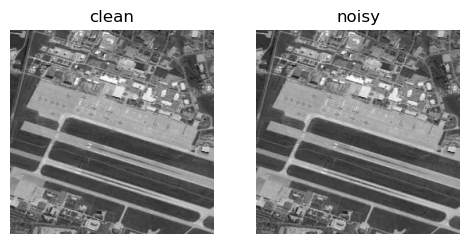

In [10]:
import matplotlib.pyplot as plt

rand = torch.randint(low=1, high=32, size=(1,)).item()
test_image = train_image_batches[rand]
test_target = train_target_batches[rand]

def compare_plots(test_image, test_target):
    plt.figure(figsize=(9,9))
    plt.subplot(3,3, 1)
    plt.imshow(test_image.squeeze(), cmap='gray')
    plt.title('clean')
    plt.axis(False)
    plt.subplot(3,3,2)
    plt.imshow(test_target.squeeze(), cmap='gray')
    plt.title('noisy')
    plt.axis(False)
    plt.show()

compare_plots(test_image, test_target)

In [11]:
class SARDespeckleModel(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.initial_stack = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.middle_stack = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                    nn.BatchNorm2d(num_features=hidden_units),
                    nn.ReLU()
                )
                for _ in range(6)
            ]
        )
        self.final_stack = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=output_shape, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
    
        self.tanh_layer = nn.Tanh()

    def forward(self, initial:torch.Tensor):
        x = self.initial_stack(initial)
        x = self.middle_stack(x)
        res = self.final_stack(x)
        despeckle = initial/(res)
        img = self.tanh_layer(despeckle)
        return img

In [12]:
model0 = SARDespeckleModel(
    input_shape=1,
    hidden_units=64,
    output_shape=1,
)
model0.to(device)

SARDespeckleModel(
  (initial_stack): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (middle_stack): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [13]:
def loss_fn(predicted, target, lambda_tv):

    mse_loss = nn.MSELoss()
    L_E = mse_loss(predicted, target)
    
    tv_h = torch.sqrt((predicted[:, :, 1:, :] - predicted[:, :, :-1, :]).pow(2) + 1e-6)  
    tv_w = torch.sqrt((predicted[:, :, :, 1:] - predicted[:, :, :, :-1]).pow(2) + 1e-6)
    L_TV = tv_h.sum() + tv_w.sum()  
    
    batch_size, _, height, width = predicted.shape
    L_TV = L_TV / (batch_size * height * width)
    
    loss = L_E + lambda_tv * L_TV
    return loss


optimizer = torch.optim.Adam(params=model0.parameters(), lr=0.0002)

In [16]:
from tqdm.auto import tqdm

EPOCHS = 1

for epoch in tqdm(range(EPOCHS)):
    total_loss =0
    model0.to(device)
    for batch, (clean_img, noise_img) in enumerate(train_dataloader):
        model0.train()
        clean_img, noise_img = clean_img.to(device), noise_img.to(device)
        img_pred = model0(noise_img)
        loss = loss_fn(img_pred, clean_img, lambda_tv=0.002)
        total_loss += loss
        optimizer.step()
        
        if batch % 10 ==0:
            print(f"We have passed {batch * len(clean_img)}/{len(train_dataloader.dataset)} samples")
            print(f'Current Accumalting Total Loss: {total_loss:.2f} | Current Loss: {loss} \n---------')
        
    
total_loss /= len(train_dataloader)
print(f"So far our train loss has been: {total_loss:.3f}%")



  0%|          | 0/1 [00:00<?, ?it/s]

We have passed 0/3000 samples
Current Accumalting Total Loss: nan | Current Loss: nan 
---------


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 13.86 GiB is allocated by PyTorch, and 291.23 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
model0.eval()
test_loss = 0
test_img_pred = 0
test_img_label = 0
with torch.inference_mode():
    for (y, X) in test_dataloader:
        y, X = y.to(device), X.to(device)
        img_pred = model0(X)
        test_loss += loss_fn(img_pred, y)
        test_img_pred = img_pred
        test_img_label = y

    test_loss /= len(test_dataloader)

print(f'Test loss: {test_loss}')

Test loss: 0.04331041872501373


In [68]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = 'sar_model'
MODEL_SAVE_PATH = MODEL_PATH/ MODEL_NAME

print(f'saving model to {MODEL_SAVE_PATH}')
torch.save(obj=model0.state_dict(), f=MODEL_SAVE_PATH)

saving model to models\sar_model


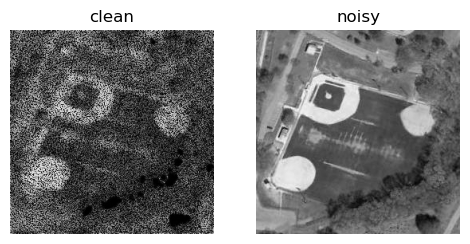

In [78]:
test_img_pred, test_img_label = test_img_pred[0].to('cpu'), test_img_label[0].to('cpu')

compare_plots(test_img_pred, test_img_label)

In [82]:
from torchmetrics.image import PeakSignalNoiseRatio
psnr = PeakSignalNoiseRatio()

psnr(test_img_pred, test_img_label)

tensor(11.6790)